In [26]:
import numpy as np

In [27]:
def kmeans_numpy(X, n_clusters, max_iters=100):

    """
    Hint:
    if implementing using numpy array:
    the shape of centroids is (n_clusters x 3), a 2D array
    The shape of labels is (for the given sample image) 512 x 512 = 262144 --> a 1D array
    """
    # Initialize cluster centroids randomly
    centroids = X[np.random.choice(len(X), n_clusters, replace=False)]
    labels = np.zeros(X.shape[0])
    size = X.shape[0]

    for _ in range(max_iters):
        # Calculate the distance from each point to each centroid
          ###########
          # Fill here
        distances = np.zeros((X.shape[0], n_clusters))
        for i in range(n_clusters):
            distances[:, i] = np.power(np.linalg.norm(X-centroids[i], axis=1), 2)
          ###########
        # Assign each point to the nearest cluster
          ###########
          # Fill here
        labels = distances.argmin(axis=1)
          ###########
        # Create an empty array to store the new centroids
        new_centroids = np.zeros((n_clusters, X.shape[1]))

        # Loop through each cluster
        for i in range(n_clusters):
            # Find all data points that belong to the current cluster
            cluster_points = X[labels == i] # fill here

            # Calculate the mean (average) of all data points in the cluster
            cluster_mean = np.mean(cluster_points, axis=0) # fill here

            # Assign the cluster mean as the new centroid
            new_centroids[i] = cluster_mean

        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids

    return centroids, labels

In [28]:
def create_compressed_image(labels, centroids, height, width, channels):
    """
    Hint:
    Assign the cluster value to the pixel of that cluster
    """
    # Step 3: Create a compressed image based on cluster centroids
    compressed_image = np.zeros((height, width, channels), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
          ###########
          # Fill here
          compressed_image[i][j] = centroids[labels[width* i + j]]
          ###########
    
    return compressed_image

Original image size: 521129 bytes
Compressed image size: 258162 bytes
Compression ratio: 2.02


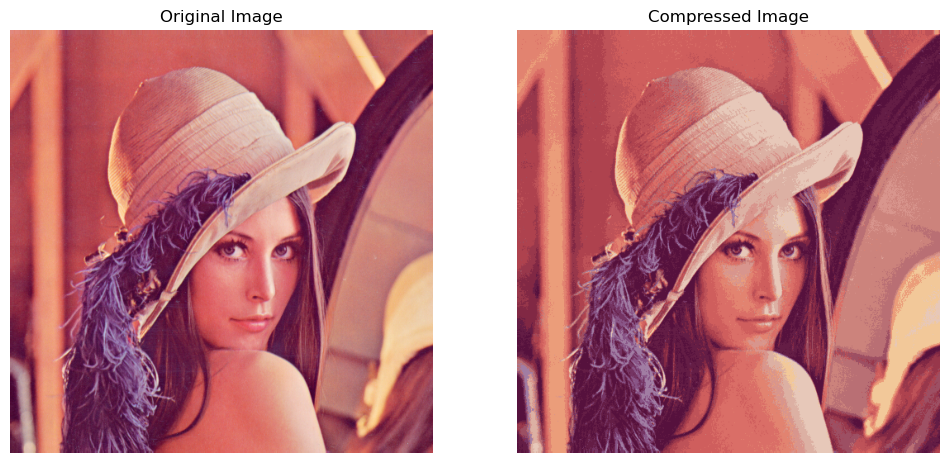

In [30]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_image_compression(image_path, num_clusters):
    # Step 1: Load the image
    original_image = cv2.imread(image_path)

    # Convert the image to RGB color space (if it's not already)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Get the dimensions of the image
    height, width, channels = original_image.shape

    # Step 2: Apply K-means clustering using numpy
    pixel_values = original_image.reshape(-1, 3)
    centroids, labels = kmeans_numpy(pixel_values, num_clusters)

    # Step 3: Create a compressed image based on cluster centroids
    compressed_image = create_compressed_image(labels, centroids, height, width, channels)

    # Step 4: Save the compressed image
    compressed_image_path = "compressed_image.png"
    cv2.imwrite(compressed_image_path, cv2.cvtColor(compressed_image, cv2.COLOR_RGB2BGR))

    # Save the original image in the same format as the compressed one
    original_image_path = "original_image.png"
    cv2.imwrite(original_image_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

    # Calculate and print the compression ratio
    original_size = os.path.getsize(original_image_path)
    compressed_size = os.path.getsize(compressed_image_path)
    compression_ratio = original_size / compressed_size

    print(f"Original image size: {original_size} bytes")
    print(f"Compressed image size: {compressed_size} bytes")
    print(f"Compression ratio: {compression_ratio:.2f}")

    # Show the original and compressed images using matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(compressed_image)
    plt.title("Compressed Image")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    image_path = "test_image.png"

    num_clusters = 20 # Adjust the number of clusters as needed
    kmeans_image_compression(image_path, num_clusters)


Part 3 Question a) Written Section:

Increasing the number of clusters results in there being are more colors on the final compressed image, thus producing a more detailed image. Although increasing the number of clusters leads to a more detailed and accurate picture, there is a tradeoff, as increasing the clusters causes the size of the compressed image to increase, becoming closer to the size of the original image. In addition, the more clusters you have the longer it takes to complete the k-means algorithm. Having fewer clusters leads to an image that is less detailed, less colourful, however the size of the compressed image is significantly smaller. 

Part 3 Question b)

In order to perform the compression with the Gausssian Mixture Model we would follow a similar procedure as to K-means. In particular:

1. First, similar to the algorithm above, we need to load the image, convert it to the RBG colour space, and find the dimensions of the image ie. the height, width and channels. In particular, these dimensions should be 512, 512 and 3 respectfully.

2. Next we need to perform the clustering technique which is the Gaussian Mixture Model. In order to perform this machine learning technique we need to do the following:
    1. First in order to perform the Expectation-Maximization algorithm we need to determine the initial values of $\Theta$, which includes the mean, covariance matrix and the prior probability for each gaussian cluster in our given num_clusters. That is we need to have the initial values of $\mu_i$, $C_i$, and $m_i$ for each cluster. However, we need to know these values from the start, as they are hyperparameters. Given that we have num_clusters gaussians, we need (3 * num_clusters + 1) hyperparameters (+1 for including the num_clusters), where each Covariance matrix is of size of dxd, where d is the number of features we have, so in this case each one is 2x2 (a pixel can have an x and y coordinate hence the 512x512 image).

    2. Once we have our hyperparameters, we can then calculate the value of each $\gamma_{i, j}$ where i is the data point and j is the number of clusters. We must calculate this value for every pixel in the image (every data point). This $\gamma_{i, j}$ = $\frac{m_jG_i(y_i; \mu_j, C_j)}{\sum_k m_kG(y_i; \mu_k, C_k)}$, where $m_j$ is the prior probability of cluster j, $G_i(y_i; \mu_j, C_j)$ is the proability density function defined as $\frac{1}{\sqrt{(2\pi)^d|C_j|}}exp(-\frac{1}{2}(y - \mu_j)^T C_j^{-1}(y - \mu_j))$. This is the Expectation part of our Expectation-Maximization Algorithm, and each $\gamma_{i, j}$ would give us a value between 0 and 1.

    3. Once we have the values for $\gamma_{i, j}$, we can compute the new values of $m_j$, $\mu_j$ and $C_j$ which can be done with the following formulas: $m_j$ = $\frac{\sum_i \gamma_{i, j}}{N}$ (where N = 262144), $\mu_j$ = $\frac{\sum_i \gamma{i, j} y_i} {\sum_i \gamma_{i, j}}$, and $C_j$ = $\frac{\sum_i \gamma_{i, j}(y_i - \mu_j)(y_i - \mu_j)^T}{\sum_i \gamma_{i, j}}$, where $m_j$ would give us a scalar value between 0 and 1 (a probability), $\mu_j$ would be a scalar value, and $C_j$ would give us another Covariance matrix which has dimensions dxd where d is the number of features, thus a 2x2 matrix.

    4. Then we would repeat steps 2 and 3 above until either reach a maximum number of desired iterations, or the model parameters $\Theta = m_j, \mu_j, C_j$ do not change.

    5. Once we have our final model parameters, we can then find which cluster each point belongs to. To do this we need to compute $\gamma_{i, j}$, and whichever cluster j has the highest probability for the given point/pixel i, we set that corresponding label to j = 1, and the remaining clusters = 0. The resulting labels would result in a 1d array of size 262144 just as the labels in the kmeans algorithm above.

    6. Once we have updated our labels, we can then return them.

3. Now that we have the labels which describes which cluster each point belongs to, we need to create the compressed image. However, unlike k-means we don't necessarily have a "cluster center" to assign each point in the cluster to. However, what we could do, is take the point with the highest value of $\gamma_{i, j}$ (closest to 1) to be the representative of that given cluster. Once we do this, we can simple loop through each pixel, and assign its colour to the colour of its cluster's best representative.

4. Then, once we have created out compressed image, we need to save the image in png format exactly like in the kmeans_image_compression.

5. Finally, we can display the saved compressed image to see how well we have compressed the image using matplotlib just as in kmeans_image_compression.